In [1]:
import sklearn
import pandas as pd
import numpy as np
import scipy
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import plotly
import xlrd
import xml.etree.ElementTree as etree
import xmltodict
# packages that I think is especially useful for this topic~~
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

import string
import itertools
import operator
import re
import copy
import unicodedata
import pickle

from nltk.corpus import stopwords
from scipy import stats
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from nltk.stem import WordNetLemmatizer

from sklearn.neighbors import KNeighborsClassifier
from sklearn.dummy import DummyClassifier
from sklearn import metrics
from sklearn.metrics import cohen_kappa_score
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler 
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import average_precision_score

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ericw\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ericw\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


<a href = "#pt1"> 1. Data Processing Task </a>


<a href = "#pt2"> 2. Troll Prediction Task I: Baseline</a>

3. Troll Prediction Task II: Improving the model

<a href = "#pt3-1"> 3-1: Using a larger/smaller number of wordsToKeep (increase top_words from 30 to 100 and 500):</a>


<a href = "#pt3-2"> 3-2: N-grams – Bigram with 100 total features and Trigram with 500 total features</a>

<a href = "#pt3-3a"> 3-3A: Decision Tree Classifier</a>

<a href = "#pt3-3b"> 3-3b: Random Forest</a>

### Data Processing Task <a id = "pt1"> </a>

In [2]:
sample_data = pd.read_csv("Assignment_4_data/IRAhandle_tweets_sample_data.csv", 
                          encoding='latin1')
sample_data

,content,account_category,troll
0,No wonder NFL players are kneeling to push the...,RightTroll,1
1,realDonaldTrump Don t worry the silent majo...,RightTroll,1
2,Roni K Patriot Happy to be here,RightTroll,1
3,Merkel si prepara a incontrare Trump anche ...,NonEnglish,0
4,Salute ecco la nuova lista delle cure gratui...,NonEnglish,0
...,...,...,...
12009,Jeez This Oâ Reilly segment dehumanizing the...,RightTroll,1
12010,TrumpBecause he wont create such stupid immig...,RightTroll,1
12011,Police are now at a second location near a res...,RightTroll,1
12012,So Trump totally plans on losing this thing I ...,RightTroll,1


In [3]:
sample_data["account_category"].unique()

array(['RightTroll', 'NonEnglish', 'LeftTroll', 'Fearmonger',
       'HashtagGamer', 'Unknown', 'NewsFeed', 'Commercial'], dtype=object)

In [4]:
sample_data[sample_data["account_category"] == 'RightTroll']

,content,account_category,troll
0,No wonder NFL players are kneeling to push the...,RightTroll,1
1,realDonaldTrump Don t worry the silent majo...,RightTroll,1
2,Roni K Patriot Happy to be here,RightTroll,1
39,wizkhalifa put in so much work on Cabin Feve...,RightTroll,1
40,IslamKills Thoughts and prayers are with all ...,RightTroll,1
...,...,...,...
12009,Jeez This Oâ Reilly segment dehumanizing the...,RightTroll,1
12010,TrumpBecause he wont create such stupid immig...,RightTroll,1
12011,Police are now at a second location near a res...,RightTroll,1
12012,So Trump totally plans on losing this thing I ...,RightTroll,1


In [5]:
sample_data[sample_data["account_category"] == 'LeftTroll']

,content,account_category,troll
42,gloed up genericpanic bet those who decided...,LeftTroll,1
43,Ima spray some on you http t co N6hsQDRBGu,LeftTroll,1
44,Man files civil rights suit against DPD office...,LeftTroll,1
45,The U S constitution has clearly been violate...,LeftTroll,1
46,She is gorgeous https t co b7MOfM2mOi,LeftTroll,1
...,...,...,...
11802,BeingBlackIs being able to be yourself Wheth...,LeftTroll,1
11803,BeingBlackIs being told to forget your histor...,LeftTroll,1
11804,Janet Jackson confirms split with husband say...,LeftTroll,1
11805,LibertÃ Ã galitÃ FraternitÃ Ne laissons...,LeftTroll,1


In [6]:
master_data = pd.read_csv("Assignment_4_data/IRAhandle_master_data.csv", 
                          encoding='latin1')
master_data

C:\Users\ericw\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3071: DtypeWarning: Columns (1,16,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,Unnamed: 0,external_author_id,author,content,region,language,publish_date,harvested_date,following,followers,...,account_type,retweet,account_category,new_june_2018,alt_external_id,tweet_id,article_url,tco1_step1,tco2_step1,tco3_step1
0,1,9.06e+17,10_GOP,We have a sitting Democrat US Senator on tria...,Unknown,English,10/1/2017 19:58,10/1/2017 19:59,1052,9636,...,Right,0,RightTroll,0,905874659358453760,9.145804e+17,http://twitter.com/905874659358453760/statuses...,https://twitter.com/10_gop/status/914580356430...,NaN,NaN
1,2,9.06e+17,10_GOP,Marshawn Lynch arrives to game in anti Trump s...,Unknown,English,10/1/2017 22:43,10/1/2017 22:43,1054,9637,...,Right,0,RightTroll,0,905874659358453760,9.146218e+17,http://twitter.com/905874659358453760/statuses...,https://twitter.com/damienwoody/status/9145685...,NaN,NaN
2,3,9.06e+17,10_GOP,Daughter of fallen Navy Sailor delivers powerf...,Unknown,English,10/1/2017 22:50,10/1/2017 22:51,1054,9637,...,Right,1,RightTroll,0,905874659358453760,9.146235e+17,http://twitter.com/905874659358453760/statuses...,https://twitter.com/10_gop/status/913231923715...,NaN,NaN
3,4,9.06e+17,10_GOP,JUST IN President Trump dedicates Presidents ...,Unknown,English,10/1/2017 23:52,10/1/2017 23:52,1062,9642,...,Right,0,RightTroll,0,905874659358453760,9.146391e+17,http://twitter.com/905874659358453760/statuses...,https://twitter.com/10_gop/status/914639143690...,NaN,NaN
4,5,9.06e+17,10_GOP,19 000 RESPECTING our National Anthem StandF...,Unknown,English,10/1/2017 2:13,10/1/2017 2:13,1050,9645,...,Right,1,RightTroll,0,905874659358453760,9.143122e+17,http://twitter.com/905874659358453760/statuses...,https://twitter.com/realDonaldTrump/status/914...,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1201325,1201326,2535818742,HAPPKENDRAHAPPY,Thank you so much and I hope you have a great ...,United States,English,9/23/2016 17:05,9/23/2016 17:05,1311,1688,...,Right,1,RightTroll,0,2535818742,7.793661e+17,http://twitter.com/happkendrahappy/statuses/77...,https://twitter.com/Patriotancestry/status/779...,NaN,NaN
1201326,1201327,2535818742,HAPPKENDRAHAPPY,OutnumberedFNC ericmtyson I d start watchi...,United States,English,9/23/2016 17:05,9/23/2016 17:05,1311,1688,...,Right,1,RightTroll,0,2535818742,7.793661e+17,http://twitter.com/happkendrahappy/statuses/77...,NaN,NaN,NaN
1201327,1201328,2535818742,HAPPKENDRAHAPPY,7 Ways to Discover Alien Planets https t c...,United States,English,9/23/2016 17:05,9/23/2016 17:05,1311,1688,...,Right,1,RightTroll,0,2535818742,7.793661e+17,http://twitter.com/happkendrahappy/statuses/77...,https://twitter.com/SPACEdotcom/status/7793612...,http://dlvr.it/MKNTzd,NaN
1201328,1201329,2535818742,HAPPKENDRAHAPPY,Video shows woman shooting at burglars during ...,United States,English,9/23/2016 17:06,9/23/2016 17:06,1311,1688,...,Right,1,RightTroll,0,2535818742,7.793663e+17,http://twitter.com/happkendrahappy/statuses/77...,http://2wsb.tv/2cp6Kll,NaN,NaN


In [7]:
master_data.dtypes

Unnamed: 0              int64
external_author_id     object
author                 object
content                object
region                 object
language               object
publish_date           object
harvested_date         object
following               int64
followers               int64
updates                 int64
post_type              object
account_type           object
retweet                 int64
account_category       object
new_june_2018           int64
alt_external_id        object
tweet_id              float64
article_url            object
tco1_step1             object
tco2_step1             object
tco3_step1             object
dtype: object

In [8]:
master_data_preprocessed = master_data[["content", "account_category"]]
master_data_preprocessed

,content,account_category
0,We have a sitting Democrat US Senator on tria...,RightTroll
1,Marshawn Lynch arrives to game in anti Trump s...,RightTroll
2,Daughter of fallen Navy Sailor delivers powerf...,RightTroll
3,JUST IN President Trump dedicates Presidents ...,RightTroll
4,19 000 RESPECTING our National Anthem StandF...,RightTroll
...,...,...
1201325,Thank you so much and I hope you have a great ...,RightTroll
1201326,OutnumberedFNC ericmtyson I d start watchi...,RightTroll
1201327,7 Ways to Discover Alien Planets https t c...,RightTroll
1201328,Video shows woman shooting at burglars during ...,RightTroll


In [9]:
master_data_preprocessed["troll"] = master_data_preprocessed["account_category"].apply(
lambda x: 1 if (x == 'LeftTroll' or x == 'RightTroll') else 0
)

# df['c2'] = df['c1'].apply(lambda x: 1 if x == 'LeftTroll' or x == 'RightTroll' else 0)
master_data_preprocessed

<ipython-input-9-a8591ea2f395>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  master_data_preprocessed["troll"] = master_data_preprocessed["account_category"].apply(


,content,account_category,troll
0,We have a sitting Democrat US Senator on tria...,RightTroll,1
1,Marshawn Lynch arrives to game in anti Trump s...,RightTroll,1
2,Daughter of fallen Navy Sailor delivers powerf...,RightTroll,1
3,JUST IN President Trump dedicates Presidents ...,RightTroll,1
4,19 000 RESPECTING our National Anthem StandF...,RightTroll,1
...,...,...,...
1201325,Thank you so much and I hope you have a great ...,RightTroll,1
1201326,OutnumberedFNC ericmtyson I d start watchi...,RightTroll,1
1201327,7 Ways to Discover Alien Planets https t c...,RightTroll,1
1201328,Video shows woman shooting at burglars during ...,RightTroll,1


In [10]:
left_trolls = master_data_preprocessed[master_data_preprocessed["account_category"] == "LeftTroll"]
left_trolls

,content,account_category,troll
5181,blacklivesmatter blm equality equalrights ...,LeftTroll,1
5182,big gun in utah so If you pay more taxes yo...,LeftTroll,1
5183,big gun in utah some of you,LeftTroll,1
5184,Black Students force the university to divest ...,LeftTroll,1
5185,Racist Maine Gov on drug problem https t...,LeftTroll,1
...,...,...,...
1182426,Store Responds to Zendaya s Claims She Was Rac...,LeftTroll,1
1182427,It would be like constructing a pipeline thro...,LeftTroll,1
1182428,10 Things You Need To Know Today September 8t...,LeftTroll,1
1182429,For The Culture alleniverson s cover story b...,LeftTroll,1


In [11]:
right_trolls = master_data_preprocessed[master_data_preprocessed["account_category"] == "RightTroll"]
right_trolls

,content,account_category,troll
0,We have a sitting Democrat US Senator on tria...,RightTroll,1
1,Marshawn Lynch arrives to game in anti Trump s...,RightTroll,1
2,Daughter of fallen Navy Sailor delivers powerf...,RightTroll,1
3,JUST IN President Trump dedicates Presidents ...,RightTroll,1
4,19 000 RESPECTING our National Anthem StandF...,RightTroll,1
...,...,...,...
1201325,Thank you so much and I hope you have a great ...,RightTroll,1
1201326,OutnumberedFNC ericmtyson I d start watchi...,RightTroll,1
1201327,7 Ways to Discover Alien Planets https t c...,RightTroll,1
1201328,Video shows woman shooting at burglars during ...,RightTroll,1


In [12]:
not_trolls = master_data_preprocessed[master_data_preprocessed["troll"] == 0]
not_trolls

,content,account_category,troll
372,ÐÑ Ð Ñ Ð Ð Ð 67 ÐÑÑ ÐºÐ Â Ð ÐµÐ Ð Ñ Ð ...,NonEnglish,0
373,ÐÑ Ð Ñ Ð Ð Ð 70 Ð Ð Ñ ÐµÐ Ñ Ð Ð Ð Ð Ñ Ñ Ñ...,NonEnglish,0
374,ÐÑ Ð Ñ Ð Ð Ð 74 ÐÑ ÐµÐ Ð Ð ÐµÐ Ñ Ñ ÐºÐ Ð ...,NonEnglish,0
375,ÐÑ Ð Ñ Ð Ð Ð 75 ÐÐ Ð Ð ÐºÐ Ð Ð Ð Ð Ð Ð Ñ ...,NonEnglish,0
376,ÐÑ Ð Ñ Ð Ð Ð 77 Ð ÐÑ Ñ Ð Ð Ð Ð Ð Ð Ð Ñ Ð...,NonEnglish,0
...,...,...,...
1195948,VW plant offenbar Verkauf von Konzernteilen ht...,NonEnglish,0
1195949,EWE Keine Korruption aber groÃe MÃ ngel ht...,NonEnglish,0
1195950,Zuzugsbremse Keine FlÃ chtlinge nach Salzgitt...,NonEnglish,0
1195951,Ritterhude drei Jahre nach der Explosion htt...,NonEnglish,0


In [13]:
len(master_data_preprocessed) == len(left_trolls) + len(not_trolls) + len(right_trolls)

True

### Troll Prediction Task I: Baseline <a id = "pt2"> </a>

#### Approach 1: Unigrams / own-written functions

In [14]:
def get_top_words(dataset_with_text, m, n):
    top_words_origin = dataset_with_text["content"].str.replace(","," ").str.cat().split()
    top_words_base = {}
    for each_word in top_words_origin:
        if each_word in top_words_base: 
            top_words_base[each_word] += 1 
        else:
            top_words_base[each_word] = 1
    top_words_base = sorted(top_words_base.items(), key=operator.itemgetter(1))
    top_words_base = dict(top_words_base[::-1])
    
    top_words_base_top_n = {k: top_words_base[k] for k in list(top_words_base)[m:n]} 


    top_words_base_no_punc_words = {}
    for word, value in top_words_base_top_n.items():
        if word[-1] in string.punctuation: 
            word = word[:-1] 
        if len(word) > 0: 
            if word in top_words_base_no_punc_words: 
                top_words_base_no_punc_words[word] += value 
            else: 
                top_words_base_no_punc_words[word] = value
    top_words_base_no_punc_sorted = sorted(top_words_base_no_punc_words.items(), 
                                           key=operator.itemgetter(1)) 
    top_words_dict_final = dict(top_words_base_no_punc_sorted[::-1])
    return top_words_dict_final

In [15]:
# 30 Most used words in all data
top_30_single_words = get_top_words(master_data_preprocessed, 0, 30)
top_30_single_words

{'Ð': 4641552,
 'Ñ': 1668444,
 't': 1259799,
 'co': 1202252,
 'https': 981513,
 'ÐµÐ': 282463,
 'to': 239262,
 'the': 215537,
 'ÐµÑ': 191811,
 'ÐºÐ': 169597,
 'in': 165136,
 'http': 151741,
 'a': 145185,
 'of': 138606,
 's': 132608,
 'Ðµ': 123696,
 'for': 104334,
 'and': 103175,
 'is': 100285,
 'I': 97552,
 'â': 92289,
 'on': 80414,
 'Ñ\x83Ð': 72215,
 'ï': 71327,
 'you': 68188,
 'Trump': 62506,
 'Ñ\x8c': 61460,
 'Ñ\x83Ñ': 56496,
 'with': 48376,
 'it': 46635}

In [16]:
# 30 Most used words in data that are trolls
top_30_single_words_trolls_only = get_top_words(
    master_data_preprocessed[master_data_preprocessed["troll"] == 1], 0, 30
)
top_30_single_words_trolls_only

{'t': 567482,
 'co': 529496,
 'https': 487417,
 'the': 157447,
 'to': 154601,
 'a': 93411,
 'of': 93248,
 's': 88430,
 'in': 84479,
 'is': 76546,
 'and': 70610,
 'for': 67103,
 'â': 65125,
 'Trump': 53165,
 'on': 52515,
 'ï': 46862,
 'you': 43492,
 'I': 42856,
 'http': 38173,
 'that': 31213,
 'it': 31163,
 'are': 31077,
 'The': 29716,
 'with': 29241,
 'ð\x9f': 26777,
 'at': 25719,
 'this': 25585,
 'be': 24248,
 'amp': 21017,
 'RT': 20604}

In [17]:
for each_word in top_30_single_words.keys():
    master_data_preprocessed["Unigram: " + each_word] = master_data_preprocessed.content.str.count(" " + each_word + " ")
    print(each_word, "occurence", master_data_preprocessed["Unigram: " + each_word].sum(), "\n")

<ipython-input-17-b0b9b07995ac>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  master_data_preprocessed["Unigram: " + each_word] = master_data_preprocessed.content.str.count(" " + each_word + " ")


Ð occurence 3049980 

Ñ occurence 1388361 

t occurence 1259754 

co occurence 1202252 

https occurence 980391 

ÐµÐ occurence 269019 

to occurence 239167 

the occurence 215382 

ÐµÑ occurence 187469 

ÐºÐ occurence 168219 

in occurence 165075 

http occurence 147830 

a occurence 145130 

of occurence 138582 

s occurence 132502 

Ðµ occurence 123577 

for occurence 104282 

and occurence 103132 

is occurence 100227 

I occurence 94081 

â occurence 91670 

on occurence 80342 

ÑÐ occurence 72013 

ï occurence 70627 

you occurence 67981 

Trump occurence 61731 

Ñ occurence 61389 

ÑÑ occurence 56465 

with occurence 48349 

it occurence 46295 



In [18]:
master_data_preprocessed

,content,account_category,troll,Unigram: Ð,Unigram: Ñ,Unigram: t,Unigram: co,Unigram: https,Unigram: ÐµÐ,Unigram: to,...,Unigram: â,Unigram: on,Unigram: ÑÐ,Unigram: ï,Unigram: you,Unigram: Trump,Unigram: Ñ,Unigram: ÑÑ,Unigram: with,Unigram: it
0,We have a sitting Democrat US Senator on tria...,RightTroll,1,0,0,1,1,1,0,0,...,0,1,0,0,1,0,0,0,0,0
1,Marshawn Lynch arrives to game in anti Trump s...,RightTroll,1,0,0,1,1,1,0,1,...,0,0,0,0,0,1,0,0,0,0
2,Daughter of fallen Navy Sailor delivers powerf...,RightTroll,1,0,0,1,1,1,0,0,...,0,1,0,0,0,0,0,0,0,0
3,JUST IN President Trump dedicates Presidents ...,RightTroll,1,0,0,1,1,1,0,1,...,0,0,0,0,0,1,0,0,0,0
4,19 000 RESPECTING our National Anthem StandF...,RightTroll,1,0,0,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1201325,Thank you so much and I hope you have a great ...,RightTroll,1,0,0,1,1,1,0,0,...,0,0,0,0,2,0,0,0,0,0
1201326,OutnumberedFNC ericmtyson I d start watchi...,RightTroll,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1201327,7 Ways to Discover Alien Planets https t c...,RightTroll,1,0,0,2,2,2,0,1,...,0,0,0,0,0,0,0,0,0,0
1201328,Video shows woman shooting at burglars during ...,RightTroll,1,0,0,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [19]:
def predict_using_MultinomialNB(tweets_dataset):
    fold_result_dicts = []
    
    X = tweets_dataset[tweets_dataset.columns.difference(['content', 'account_category', 'troll'])]
    # X = tweets_dataset[tweets_dataset.columns.difference(['troll'])]
    y = tweets_dataset['troll']
    kf = KFold(n_splits=4, random_state=577, shuffle=True)

    fold_idx = 1
    print("MultinomialNB with unigrams as features.",)
    for train_index, test_index in kf.split(X):

            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]

            multiNB_mdl = MultinomialNB()        
            multiNB_mdl.fit(X_train, y_train)

            y_pred = multiNB_mdl.predict(X_test)

            accuracy_score_lr = metrics.accuracy_score(y_test, y_pred)
            kappa_lr = cohen_kappa_score(y_test, y_pred)
            confustion_matrix_lr = metrics.confusion_matrix(y_test, y_pred)
            
            single_fold_dict = {
                "Fold Index": fold_idx,
                "Accuracy": accuracy_score_lr,
                "Kappa": kappa_lr,
                "Matrix": np.array(confustion_matrix_lr)
            }
            
            fold_result_dicts.append(single_fold_dict)
            
            print("Fold No.", fold_idx, 
                  ", Accuracy:", accuracy_score_lr,
                  ", Kappa:", kappa_lr)
            print(confustion_matrix_lr)
            fold_idx += 1
    return fold_result_dicts

In [20]:
def show_scores_and_plot_matrices(result_dicts):
    summed_matrix = np.array([[0, 0], [0, 0]])
    for each in result_dicts:
        df_cm = pd.DataFrame(each["Matrix"])
        df_cm.index.name = 'Actual'
        df_cm.columns.name = 'Predicted'
        print("Fold", each["Fold Index"], "Accuracy:", each["Accuracy"], "Kappa:", each["Kappa"]) 
        summed_matrix = np.add(summed_matrix, each["Matrix"])  

    averaged_matrix = np.divide(summed_matrix, 4)
    
    plt.figure(figsize = (16,9))
    sns.set(font_scale=1.4)#label size
    sns.heatmap(averaged_matrix, cmap="Greens", annot=True,annot_kws={"size": 16})
    
    # Averaging the 4 folds might be better than adding all 4 together

MultinomialNB with unigrams as features.
Fold No. 1 , Accuracy: 0.6084512857394958 , Kappa: 0.2588808752387295
[[ 50521 113073]
 [  4522 132217]]
Fold No. 2 , Accuracy: 0.6068064448462207 , Kappa: 0.2572943538890047
[[ 50422 113659]
 [  4430 131822]]
Fold No. 3 , Accuracy: 0.6079771719297311 , Kappa: 0.2591598102291125
[[ 50632 113355]
 [  4382 131963]]
Fold No. 4 , Accuracy: 0.6070215628038305 , Kappa: 0.2587274810057082
[[ 50806 113668]
 [  4356 131502]]
Fold 1 Accuracy: 0.6084512857394958 Kappa: 0.2588808752387295
Fold 2 Accuracy: 0.6068064448462207 Kappa: 0.2572943538890047
Fold 3 Accuracy: 0.6079771719297311 Kappa: 0.2591598102291125
Fold 4 Accuracy: 0.6070215628038305 Kappa: 0.2587274810057082


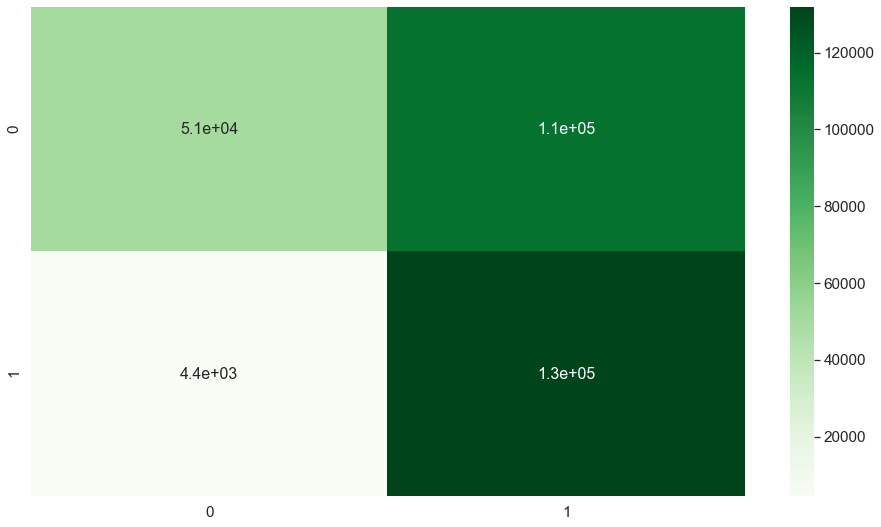

In [21]:
multiNB_matrices = predict_using_MultinomialNB(master_data_preprocessed)
show_scores_and_plot_matrices(multiNB_matrices)

### Troll Prediction Task II: Improving the model <a id = "pt3"> </a>

#### Approach 1: Using a larger/smaller number of wordsToKeep (increase top_words from 30 to 100 and 500): <a id = "pt3-1"> </a>

In [49]:
# 100 Most used words in all data
top_100_single_words = get_top_words(master_data_preprocessed, 0, 100)
for each_word in top_100_single_words.keys():
    master_data_preprocessed["Unigram: " + each_word] = master_data_preprocessed.content.str.count(" " + each_word + " ")
    print(each_word, "occurence", master_data_preprocessed["Unigram: " + each_word].sum(), "\n")

Ð occurence 3049980 

Ñ occurence 1388361 

t occurence 1259754 

co occurence 1202252 

https occurence 980391 

ÐµÐ occurence 269019 

to occurence 239167 

the occurence 215382 

ÐµÑ occurence 187469 

ÐºÐ occurence 168219 

in occurence 165075 

http occurence 147830 

a occurence 145130 

of occurence 138582 

s occurence 132502 

Ðµ occurence 123577 

for occurence 104282 

and occurence 103132 

is occurence 100227 

I occurence 94081 

â occurence 91670 

on occurence 80342 

ÑÐ occurence 72013 

ï occurence 70627 

you occurence 67981 

Trump occurence 61731 

Ñ occurence 61389 

ÑÑ occurence 56465 

with occurence 48349 

it occurence 46295 

Â occurence 44543 

at occurence 45319 

that occurence 45144 

Ñ occurence 39824 

The occurence 37432 

are occurence 39463 

ÐºÑ occurence 37251 

workout occurence 37182 

be occurence 36464 

this occurence 34566 

my occurence 34198 

ð occurence 29339 

by occurence 28413 

not occurence 28057 

your occurence 27068 

from oc

In [50]:
master_data_preprocessed

,content,account_category,troll,Unigram: Ð,Unigram: Ñ,Unigram: t,Unigram: co,Unigram: https,Unigram: ÐµÐ,Unigram: to,...,Unigram: what,Unigram: Just,Unigram: 1,Unigram: Ñ,Unigram: Ø,Unigram: It,Unigram: re,Unigram: Hillary,Unigram: or,Unigram: In
0,We have a sitting Democrat US Senator on tria...,RightTroll,1,0,0,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Marshawn Lynch arrives to game in anti Trump s...,RightTroll,1,0,0,1,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0
2,Daughter of fallen Navy Sailor delivers powerf...,RightTroll,1,0,0,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,JUST IN President Trump dedicates Presidents ...,RightTroll,1,0,0,1,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0
4,19 000 RESPECTING our National Anthem StandF...,RightTroll,1,0,0,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1201325,Thank you so much and I hope you have a great ...,RightTroll,1,0,0,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1201326,OutnumberedFNC ericmtyson I d start watchi...,RightTroll,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1201327,7 Ways to Discover Alien Planets https t c...,RightTroll,1,0,0,2,2,2,0,1,...,0,0,0,0,0,0,0,0,0,0
1201328,Video shows woman shooting at burglars during ...,RightTroll,1,0,0,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0


MultinomialNB with unigrams as features.
Fold No. 1 , Accuracy: 0.6255456443347884 , Kappa: 0.29081725813999204
[[ 53613 109981]
 [  2480 134259]]
Fold No. 2 , Accuracy: 0.6234779394871692 , Kappa: 0.28841906588871447
[[ 53367 110714]
 [  2368 133884]]
Fold No. 3 , Accuracy: 0.624845171343713 , Kappa: 0.29058153936211517
[[ 53719 110268]
 [  2403 133942]]
Fold No. 4 , Accuracy: 0.6241459451540295 , Kappa: 0.29050302369555836
[[ 53997 110477]
 [  2404 133454]]
Fold 1 Accuracy: 0.6255456443347884 Kappa: 0.29081725813999204
Fold 2 Accuracy: 0.6234779394871692 Kappa: 0.28841906588871447
Fold 3 Accuracy: 0.624845171343713 Kappa: 0.29058153936211517
Fold 4 Accuracy: 0.6241459451540295 Kappa: 0.29050302369555836


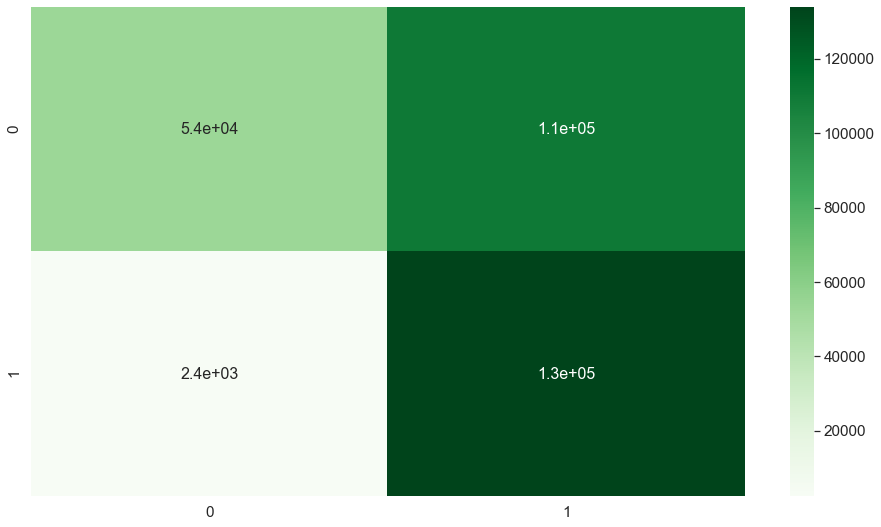

In [51]:
multiNB_matrices = predict_using_MultinomialNB(master_data_preprocessed)
show_scores_and_plot_matrices(multiNB_matrices)

Ð occurence 3049980 

Ñ occurence 1388361 

t occurence 1259754 

co occurence 1202252 

https occurence 980391 

ÐµÐ occurence 269019 

to occurence 239167 

the occurence 215382 

ÐµÑ occurence 187469 

ÐºÐ occurence 168219 

in occurence 165075 

http occurence 147830 

a occurence 145130 

of occurence 138582 

s occurence 132502 

Ðµ occurence 123577 

for occurence 104282 

and occurence 103132 

is occurence 100227 

I occurence 94081 

â occurence 91670 

on occurence 80342 

ÑÐ occurence 72013 

ï occurence 70627 

you occurence 67981 

Trump occurence 61731 

Ñ occurence 61389 

ÑÑ occurence 56465 

with occurence 48349 

it occurence 46295 

Â occurence 44543 

at occurence 45319 

that occurence 45144 

Ñ occurence 39824 

The occurence 37432 

are occurence 39463 

ÐºÑ occurence 37251 

workout occurence 37182 

be occurence 36464 

this occurence 34566 

my occurence 34198 

ð occurence 29339 

by occurence 28413 

not occurence 28057 

your occurence 27068 

from oc

own occurence 3711 

Merkel occurence 3686 

John occurence 3627 

11 occurence 3627 

family occurence 3660 

keep occurence 3683 

morning occurence 3632 

California occurence 3609 

City occurence 3635 

didn occurence 3666 

More occurence 3532 

next occurence 3609 

Antifa occurence 3606 

free occurence 3585 

Against occurence 3593 

fire occurence 3568 

15 occurence 3524 

does occurence 3564 

thing occurence 3546 

things occurence 3542 

two occurence 3551 

give occurence 3546 

ÐÑÑ occurence 3391 

Dems occurence 3507 

start occurence 3513 

call occurence 3514 

ÑÑ occurence 3497 

Congress occurence 3434 

doesn occurence 3483 

ÑÐºÑ occurence 3482 

auf occurence 3470 

ÐºÑÐ occurence 3450 

car occurence 3416 

during occurence 3436 

Democrats occurence 3380 

ÐºÑÑ occurence 3431 

FoxNews occurence 3361 

NOT occurence 3399 

Baltimore occurence 3361 

T occurence 3350 

D occurence 3337 

trying occurence 3387 

big occurence 3372 

12 occurence 3307 

we

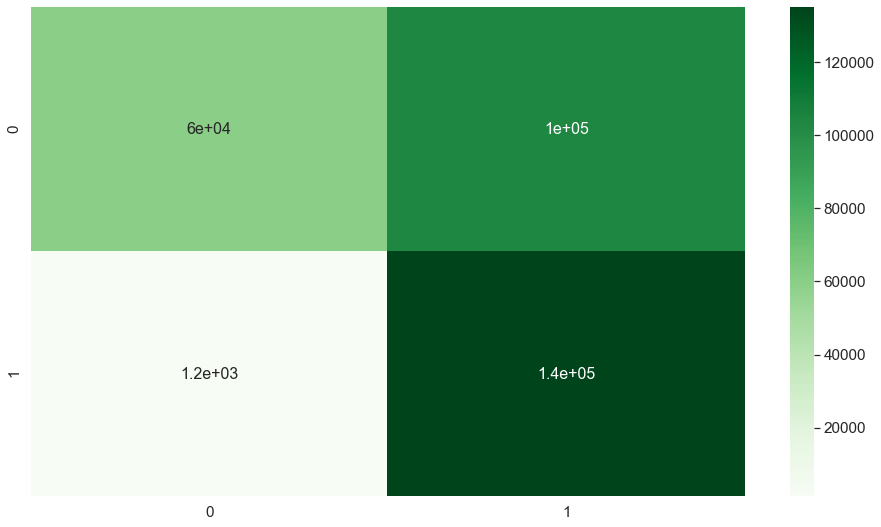

In [52]:
# 500 Most used words in all data
top_500_single_words = get_top_words(master_data_preprocessed, 0, 500)
for each_word in top_500_single_words.keys():
    master_data_preprocessed["Unigram: " + each_word] = master_data_preprocessed.content.str.count(" " + each_word + " ")
    print(each_word, "occurence", master_data_preprocessed["Unigram: " + each_word].sum(), "\n")

multiNB_matrices = predict_using_MultinomialNB(master_data_preprocessed)
show_scores_and_plot_matrices(multiNB_matrices)

In [35]:
"""
def basic_clean(text):
  """
  #A simple function to clean up the data. All the words that
  #are not designated as a stop word is then lemmatized after
  #encoding and basic regex parsing are performed.
  """
  wnl = nltk.stem.WordNetLemmatizer()
  stopwords = nltk.corpus.stopwords.words('english')
  text = (unicodedata.normalize('NFKD', text)
    .encode('ascii', 'ignore')
    .decode('latin1', 'ignore')
    .lower())
  words = re.sub(r'[^\w\s]', '', text).split()
  return [wnl.lemmatize(word) for word in words if word not in stopwords]

words = basic_clean(''.join(str(master_data_preprocessed['content'].tolist())))
top_10_bigram = (pd.Series(nltk.ngrams(words, 2)).value_counts())[:10]
top_10_bigram 
"""

(n, n)        1353013
(http, co)    1201602
(n, http)       93396
(n, nx83)       83303
(nx83, n)       76490
(n, nx8c)       76060
(nx8c, n)       62091
(nx83n, n)      43711
(n, nx83n)      42003
(nx88, n)       26480
dtype: int64

#### Approach 2: N-grams <a id = "pt3-2"> </a>
    - (a) Bigram with 100 total features
    - (b) Trigram with 500 total features

In [40]:
word_vectorizer = CountVectorizer(ngram_range=(1,2), analyzer='word', max_features=100)
sparse_matrix = word_vectorizer.fit_transform(master_data_preprocessed['content'])
frequencies = sum(sparse_matrix).toarray()[0]
the_cv_df = pd.DataFrame(frequencies, index=word_vectorizer.get_feature_names(), 
                         columns=['frequency'])
the_cv_df

,frequency
about,27314
after,26541
all,32558
amp,22345
an,20667
...,...
ðºð ðµ,24714
ðºð ðµð,38970
ðºð ðµñ,30768
ðºð ðºð,27905


In [53]:
top_100_ngrams = the_cv_df.to_dict()['frequency']

In [54]:
master_data_preprocessed = master_data_preprocessed[["content", "account_category", "troll"]]
master_data_preprocessed

,content,account_category,troll
0,We have a sitting Democrat US Senator on tria...,RightTroll,1
1,Marshawn Lynch arrives to game in anti Trump s...,RightTroll,1
2,Daughter of fallen Navy Sailor delivers powerf...,RightTroll,1
3,JUST IN President Trump dedicates Presidents ...,RightTroll,1
4,19 000 RESPECTING our National Anthem StandF...,RightTroll,1
...,...,...,...
1201325,Thank you so much and I hope you have a great ...,RightTroll,1
1201326,OutnumberedFNC ericmtyson I d start watchi...,RightTroll,1
1201327,7 Ways to Discover Alien Planets https t c...,RightTroll,1
1201328,Video shows woman shooting at burglars during ...,RightTroll,1


about occurence 20817 

after occurence 17801 

all occurence 23416 

amp occurence 22310 

an occurence 18186 

and occurence 103132 

are occurence 39463 

as occurence 25569 

at occurence 45319 

be occurence 36464 

black occurence 7208 

breaking occurence 1853 

but occurence 18157 

by occurence 28413 

can occurence 20495 

co occurence 1202252 

do occurence 15746 

don occurence 12896 

for occurence 104282 

from occurence 27050 

get occurence 16601 

has occurence 16539 

have occurence 26761 

he occurence 17738 

his occurence 16478 

how occurence 10276 

http occurence 147830 

http co occurence 0 

https occurence 980391 

https co occurence 0 

if occurence 12415 

in occurence 165075 

in the occurence 18507 

is occurence 100227 

it occurence 46295 

just occurence 16894 

like occurence 18611 

man occurence 11258 

me occurence 22122 

more occurence 14421 

my occurence 34198 

new occurence 10655 

news occurence 6847 

no occurence 12933 

not occurence 2805

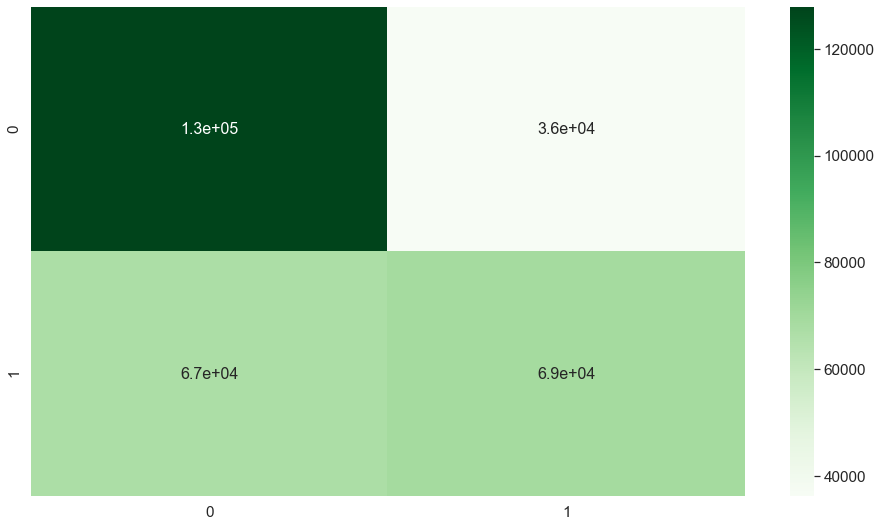

In [56]:
for each_word in top_100_ngrams.keys():
    master_data_preprocessed["N-gram: " + each_word] = master_data_preprocessed.content.str.count(" " + each_word + " ")
    print(each_word, "occurence", master_data_preprocessed["N-gram: " + each_word].sum(), "\n")

multiNB_matrices = predict_using_MultinomialNB(master_data_preprocessed)
show_scores_and_plot_matrices(multiNB_matrices)

In [57]:
word_vectorizer = CountVectorizer(ngram_range=(1,3), analyzer='word', max_features=500)
sparse_matrix = word_vectorizer.fit_transform(master_data_preprocessed['content'])
frequencies = sum(sparse_matrix).toarray()[0]
the_cv_df_500_trigram = pd.DataFrame(frequencies, index=word_vectorizer.get_feature_names(), 
                         columns=['frequency'])
top_500_ngrams = the_cv_df_500_trigram.to_dict()['frequency']
master_data_preprocessed = master_data_preprocessed[["content", "account_category", "troll"]]
the_cv_df_500_trigram

,frequency
000,5093
10,7525
100,4175
11,4024
15,4015
...,...
ðºñ https co,5421
ðºñ ðµ,7185
ðºñ ðµð,13515
ðºñ ðµñ,10060


<ipython-input-58-450682e0c7ec>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  master_data_preprocessed["N-gram: " + each_word] = master_data_preprocessed.content.str.count(" " + each_word + " ")


000 occurence 4841 

10 occurence 6660 

100 occurence 4007 

11 occurence 3627 

15 occurence 3524 

20 occurence 3759 

2016 occurence 6521 

2017 occurence 6458 

about occurence 20817 

after occurence 17801 

again occurence 4355 

against occurence 5803 

all occurence 23416 

all the occurence 3313 

always occurence 4043 

am occurence 5928 

america occurence 130 

american occurence 99 

americans occurence 42 

amp occurence 22310 

an occurence 18186 

and occurence 103132 

and the occurence 3906 

another occurence 3295 

anti occurence 1958 

antifa occurence 203 

any occurence 4305 

are occurence 39463 

arrested occurence 3783 

as occurence 25569 

at occurence 45319 

at https occurence 3430 

at https co occurence 0 

at the occurence 5376 

attack occurence 2842 

back occurence 8225 

bad occurence 3107 

baltimore occurence 61 

be occurence 36464 

because occurence 6612 

been occurence 7256 

before occurence 5112 

being occurence 7501 

believe occurence 3

where occurence 3308 

which occurence 2284 

while occurence 4069 

white occurence 5413 

white house occurence 61 

who occurence 19399 

why occurence 6312 

will occurence 22858 

will be occurence 3931 

win occurence 3975 

with occurence 48349 

with the occurence 3497 

woman occurence 5315 

women occurence 4665 

won occurence 4426 

work occurence 5634 

workout occurence 37182 

world occurence 5117 

would occurence 10001 

year occurence 8400 

year old occurence 3681 

years occurence 6083 

you occurence 67981 

you are occurence 2680 

you can occurence 2529 

you re occurence 4015 

your occurence 27068 

ºð occurence 0 

ðµ occurence 0 

ðµ http occurence 0 

ðµ http co occurence 0 

ðµ https occurence 0 

ðµ https co occurence 0 

ðµ ðµ occurence 0 

ðµ ðµð occurence 0 

ðµ ðµð ðµ occurence 0 

ðµ ðµð ðµð occurence 0 

ðµ ðµð ðµñ occurence 0 

ðµ ðµð ðºð occurence 0 

ðµ ðµñ occurence 0 

ðµ ðµñ ðµð occurence 0 

ðµ ðµñ ðµñ occurence 0 

ðµ ðºð occurence 0 

ðµ ðºñ

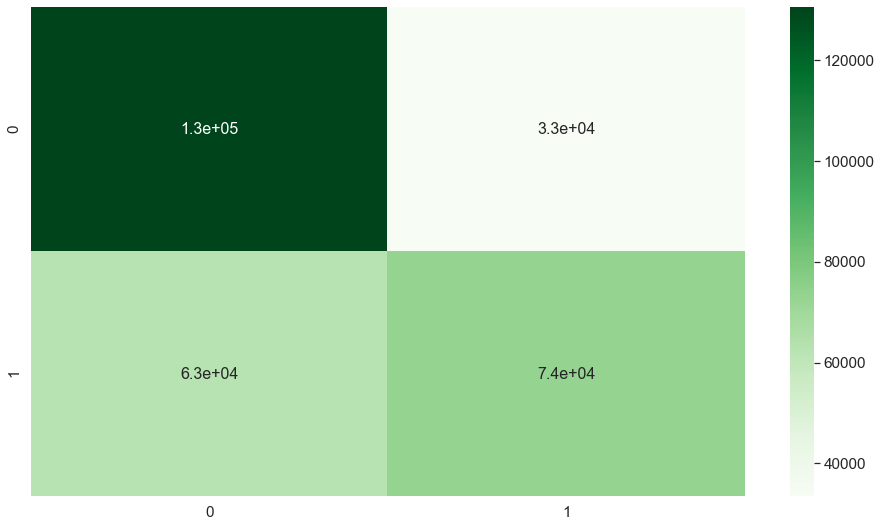

In [58]:
for each_word in top_500_ngrams.keys():
    master_data_preprocessed["N-gram: " + each_word] = master_data_preprocessed.content.str.count(" " + each_word + " ")
    print(each_word, "occurence", master_data_preprocessed["N-gram: " + each_word].sum(), "\n")

multiNB_matrices = predict_using_MultinomialNB(master_data_preprocessed)
show_scores_and_plot_matrices(multiNB_matrices)

#### Approach 3: TREES! <a id = "pt3-3a"> </a>
    - (a) DecisionTreeClassifier
    - (b) RandomForest
Note: Computer Memory (RAM) constantly hitting the 95% benchmark with this model.
This model seems very dangerous. I probably won't use it again...

In [23]:
def predict_using_DecisionTree(tweets_dataset):
    fold_result_dicts = []
    
    X = tweets_dataset[tweets_dataset.columns.difference(['content', 'account_category', 'troll'])]
    # X = tweets_dataset[tweets_dataset.columns.difference(['troll'])]
    y = tweets_dataset['troll']
    kf = KFold(n_splits=4, random_state=577, shuffle=True)

    fold_idx = 1
    print("Decision Tree method that can be recycled. Sounds eco-friendly amIRight",)
    for train_index, test_index in kf.split(X):

            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]
            
            dtc_mdl = DecisionTreeClassifier()        
            dtc_mdl.fit(X_train, y_train)

            y_pred = dtc_mdl.predict(X_test)

            accuracy_score_lr = metrics.accuracy_score(y_test, y_pred)
            kappa_lr = cohen_kappa_score(y_test, y_pred)
            confustion_matrix_lr = metrics.confusion_matrix(y_test, y_pred)
            
            single_fold_dict = {
                "Fold Index": fold_idx,
                "Accuracy": accuracy_score_lr,
                "Kappa": kappa_lr,
                "Matrix": np.array(confustion_matrix_lr)
            }
            
            fold_result_dicts.append(single_fold_dict)
            
            print("Fold No.", fold_idx, 
                  ", Accuracy:", accuracy_score_lr,
                  ", Kappa:", kappa_lr)
            print(confustion_matrix_lr)
            fold_idx += 1
    return fold_result_dicts

In [26]:
# Dataframe from the baseline
master_data_preprocessed

,content,account_category,troll,Unigram: Ð,Unigram: Ñ,Unigram: t,Unigram: co,Unigram: https,Unigram: ÐµÐ,Unigram: to,...,Unigram: â,Unigram: on,Unigram: ÑÐ,Unigram: ï,Unigram: you,Unigram: Trump,Unigram: Ñ,Unigram: ÑÑ,Unigram: with,Unigram: it
0,We have a sitting Democrat US Senator on tria...,RightTroll,1,0,0,1,1,1,0,0,...,0,1,0,0,1,0,0,0,0,0
1,Marshawn Lynch arrives to game in anti Trump s...,RightTroll,1,0,0,1,1,1,0,1,...,0,0,0,0,0,1,0,0,0,0
2,Daughter of fallen Navy Sailor delivers powerf...,RightTroll,1,0,0,1,1,1,0,0,...,0,1,0,0,0,0,0,0,0,0
3,JUST IN President Trump dedicates Presidents ...,RightTroll,1,0,0,1,1,1,0,1,...,0,0,0,0,0,1,0,0,0,0
4,19 000 RESPECTING our National Anthem StandF...,RightTroll,1,0,0,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1201325,Thank you so much and I hope you have a great ...,RightTroll,1,0,0,1,1,1,0,0,...,0,0,0,0,2,0,0,0,0,0
1201326,OutnumberedFNC ericmtyson I d start watchi...,RightTroll,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1201327,7 Ways to Discover Alien Planets https t c...,RightTroll,1,0,0,2,2,2,0,1,...,0,0,0,0,0,0,0,0,0,0
1201328,Video shows woman shooting at burglars during ...,RightTroll,1,0,0,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0


Decision Tree with ngrams as features.
Fold No. 1 , Accuracy: 0.7762250568535592 , Kappa: 0.5476669678184867
[[132156  31438]
 [ 35769 100970]]
Fold No. 2 , Accuracy: 0.7747466978320731 , Kappa: 0.54450976284435
[[132164  31917]
 [ 35734 100518]]
Fold No. 3 , Accuracy: 0.7767004515003396 , Kappa: 0.5487016611909289
[[132039  31948]
 [ 35116 101229]]
Fold No. 4 , Accuracy: 0.7761610484397267 , Kappa: 0.5473522549705439
[[132359  32115]
 [ 35111 100747]]
Fold 1 Accuracy: 0.7762250568535592 Kappa: 0.5476669678184867
Fold 2 Accuracy: 0.7747466978320731 Kappa: 0.54450976284435
Fold 3 Accuracy: 0.7767004515003396 Kappa: 0.5487016611909289
Fold 4 Accuracy: 0.7761610484397267 Kappa: 0.5473522549705439


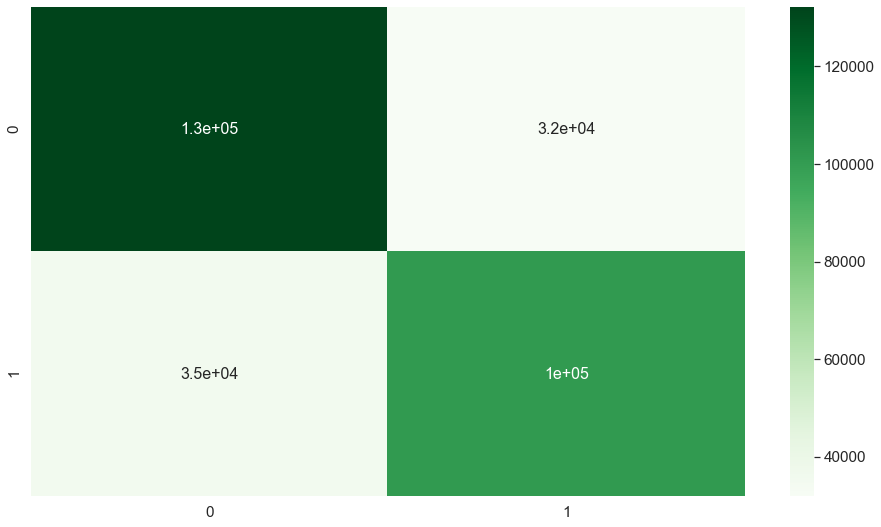

In [25]:
DTC_matrices_baseline = predict_using_DecisionTree(master_data_preprocessed)
show_scores_and_plot_matrices(DTC_matrices_baseline)

#### Now trying it on a many more features: 500 N-grams!!

In [61]:
# dataframe from Improved model: 500-feature N-grams 
master_data_preprocessed.tail(5)

,content,account_category,troll,N-gram: 000,N-gram: 10,N-gram: 100,N-gram: 11,N-gram: 15,N-gram: 20,N-gram: 2016,...,N-gram: ðºð ðºð ðºð,N-gram: ðºð ðºñ,N-gram: ðºðµ,N-gram: ðºñ,N-gram: ðºñ https,N-gram: ðºñ https co,N-gram: ðºñ ðµ,N-gram: ðºñ ðµð,N-gram: ðºñ ðµñ,N-gram: ðºñ ðºð
1201325,Thank you so much and I hope you have a great ...,RightTroll,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1201326,OutnumberedFNC ericmtyson I d start watchi...,RightTroll,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1201327,7 Ways to Discover Alien Planets https t c...,RightTroll,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1201328,Video shows woman shooting at burglars during ...,RightTroll,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1201329,Aside from watching this woman defend her life...,RightTroll,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Fold 1 Accuracy: 0.7739509144849217 Kappa: 0.5364565495549249
Fold 2 Accuracy: 0.7746634568961785 Kappa: 0.5373644353905793
Fold 3 Accuracy: 0.7749723639172649 Kappa: 0.538037510928925
Fold 4 Accuracy: 0.7753852403340303 Kappa: 0.538492441069532


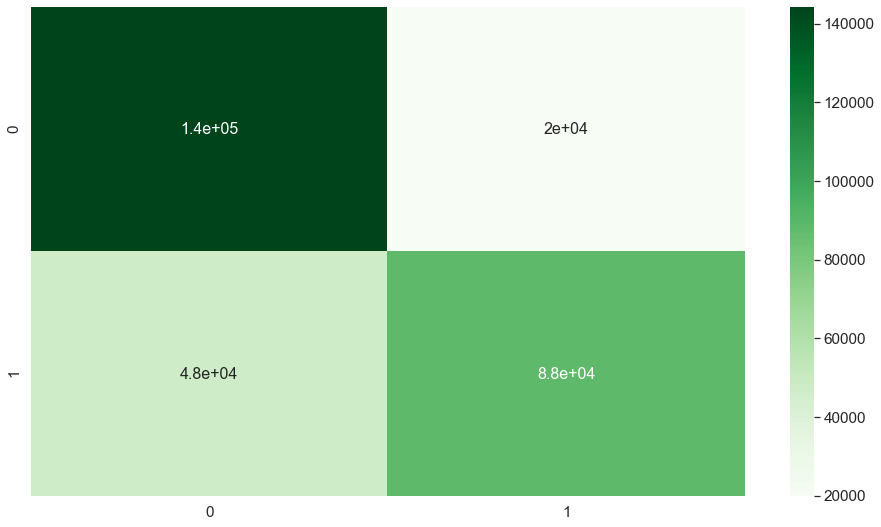

In [65]:
DTC_matrices = predict_using_DecisionTree(master_data_preprocessed)
show_scores_and_plot_matrices(DTC_matrices)

In [ ]:
# The 500-feature frame sacrifice too much runtime, almost crashing the machine memory
# for no improvement over the 30-feature baseline. Trying Random Forest on the baseline instead:

Decision Tree with ngrams as features.
Fold No. 1 , Accuracy: 0.8444027129885827 , Kappa: 0.6852909239181564
[[142892  20702]
 [ 26029 110710]]
Fold No. 2 , Accuracy: 0.8441563198183349 , Kappa: 0.6845844492545337
[[143299  20782]
 [ 26023 110229]]
Fold No. 3 , Accuracy: 0.8447351597565361 , Kappa: 0.6858539762649483
[[143152  20835]
 [ 25796 110549]]
Fold No. 4 , Accuracy: 0.8451546954703462 , Kappa: 0.6864801836690962
[[143692  20782]
 [ 25723 110135]]
Fold 1 Accuracy: 0.8444027129885827 Kappa: 0.6852909239181564
Fold 2 Accuracy: 0.8441563198183349 Kappa: 0.6845844492545337
Fold 3 Accuracy: 0.8447351597565361 Kappa: 0.6858539762649483
Fold 4 Accuracy: 0.8451546954703462 Kappa: 0.6864801836690962


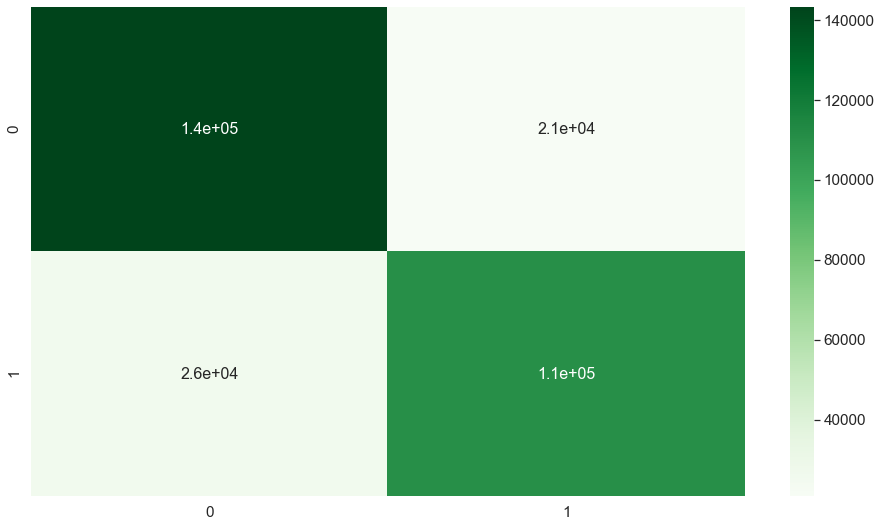

In [54]:
# But first, try this on 500 unigrams
DTC_matrices = predict_using_DecisionTree(master_data_preprocessed)
show_scores_and_plot_matrices(DTC_matrices)

### Time to evolve Decision Tree into Random Forest~! <a id = "pt3-3b"> </a>

In [25]:
def predict_using_RandomForest(tweets_dataset):
    fold_result_dicts = []
    
    X = tweets_dataset[tweets_dataset.columns.difference(['content', 'account_category', 'troll'])]
    # X = tweets_dataset[tweets_dataset.columns.difference(['troll'])]
    y = tweets_dataset['troll']
    kf = KFold(n_splits=4, random_state=577, shuffle=True)

    fold_idx = 1
    print("A forest of so many decision trees. Sounds quadruple eco-friendly amIRight",)
    for train_index, test_index in kf.split(X):

            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]
            
            clf=RandomForestClassifier(n_estimators=100)
            clf.fit(X_train,y_train)

            y_pred=clf.predict(X_test)

            accuracy_score_lr = metrics.accuracy_score(y_test, y_pred)
            kappa_lr = cohen_kappa_score(y_test, y_pred)
            confustion_matrix_lr = metrics.confusion_matrix(y_test, y_pred)
            
            single_fold_dict = {
                "Fold Index": fold_idx,
                "Accuracy": accuracy_score_lr,
                "Kappa": kappa_lr,
                "Matrix": np.array(confustion_matrix_lr)
            }
            
            fold_result_dicts.append(single_fold_dict)
            
            print("Fold No.", fold_idx, 
                  ", Accuracy:", accuracy_score_lr,
                  ", Kappa:", kappa_lr)
            print(confustion_matrix_lr)
            fold_idx += 1
    return fold_result_dicts

Decision Tree method that can be recycled. Sounds eco-friendly amIRight
Fold No. 1 , Accuracy: 0.78128943539338 , Kappa: 0.5586463689351198
[[131519  32075]
 [ 33611 103128]]
Fold No. 2 , Accuracy: 0.7797011983365132 , Kappa: 0.5554679861888203
[[131214  32867]
 [ 33296 102956]]
Fold No. 3 , Accuracy: 0.7816716167441365 , Kappa: 0.5595710497450568
[[131278  32709]
 [ 32862 103483]]
Fold No. 4 , Accuracy: 0.7812887071640717 , Kappa: 0.5585308760622478
[[131700  32774]
 [ 32912 102946]]
Fold 1 Accuracy: 0.78128943539338 Kappa: 0.5586463689351198
Fold 2 Accuracy: 0.7797011983365132 Kappa: 0.5554679861888203
Fold 3 Accuracy: 0.7816716167441365 Kappa: 0.5595710497450568
Fold 4 Accuracy: 0.7812887071640717 Kappa: 0.5585308760622478


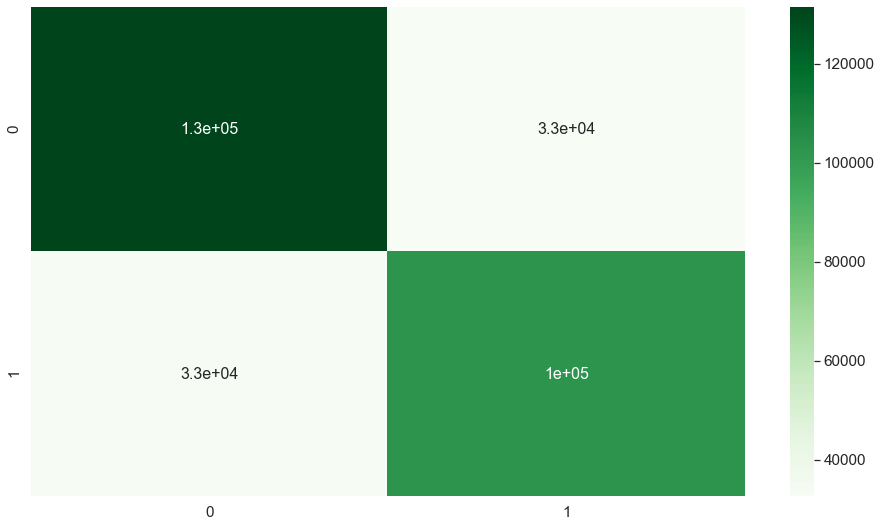

In [26]:
# master_data_preprocessed
RF_cos_we_can = predict_using_RandomForest(master_data_preprocessed)
show_scores_and_plot_matrices(RF_cos_we_can)

Ð occurence 3049980 

Ñ occurence 1388361 

t occurence 1259754 

co occurence 1202252 

https occurence 980391 

ÐµÐ occurence 269019 

to occurence 239167 

the occurence 215382 

ÐµÑ occurence 187469 

ÐºÐ occurence 168219 

in occurence 165075 

http occurence 147830 

a occurence 145130 

of occurence 138582 

s occurence 132502 

Ðµ occurence 123577 

for occurence 104282 

and occurence 103132 

is occurence 100227 

I occurence 94081 

â occurence 91670 

on occurence 80342 

ÑÐ occurence 72013 

ï occurence 70627 

you occurence 67981 

Trump occurence 61731 

Ñ occurence 61389 

ÑÑ occurence 56465 

with occurence 48349 

it occurence 46295 

Â occurence 44543 

at occurence 45319 

that occurence 45144 

Ñ occurence 39824 

The occurence 37432 

are occurence 39463 

ÐºÑ occurence 37251 

workout occurence 37182 

be occurence 36464 

this occurence 34566 

my occurence 34198 

ð occurence 29339 

by occurence 28413 

not occurence 28057 

your occurence 27068 

from oc

own occurence 3711 

Merkel occurence 3686 

John occurence 3627 

11 occurence 3627 

family occurence 3660 

keep occurence 3683 

morning occurence 3632 

California occurence 3609 

City occurence 3635 

didn occurence 3666 

More occurence 3532 

next occurence 3609 

Antifa occurence 3606 

free occurence 3585 

Against occurence 3593 

fire occurence 3568 

15 occurence 3524 

does occurence 3564 

thing occurence 3546 

things occurence 3542 

two occurence 3551 

give occurence 3546 

ÐÑÑ occurence 3391 

Dems occurence 3507 

start occurence 3513 

call occurence 3514 

ÑÑ occurence 3497 

Congress occurence 3434 

doesn occurence 3483 

ÑÐºÑ occurence 3482 

auf occurence 3470 

ÐºÑÐ occurence 3450 

car occurence 3416 

during occurence 3436 

Democrats occurence 3380 

ÐºÑÑ occurence 3431 

FoxNews occurence 3361 

NOT occurence 3399 

Baltimore occurence 3361 

T occurence 3350 

D occurence 3337 

trying occurence 3387 

big occurence 3372 

12 occurence 3307 

we

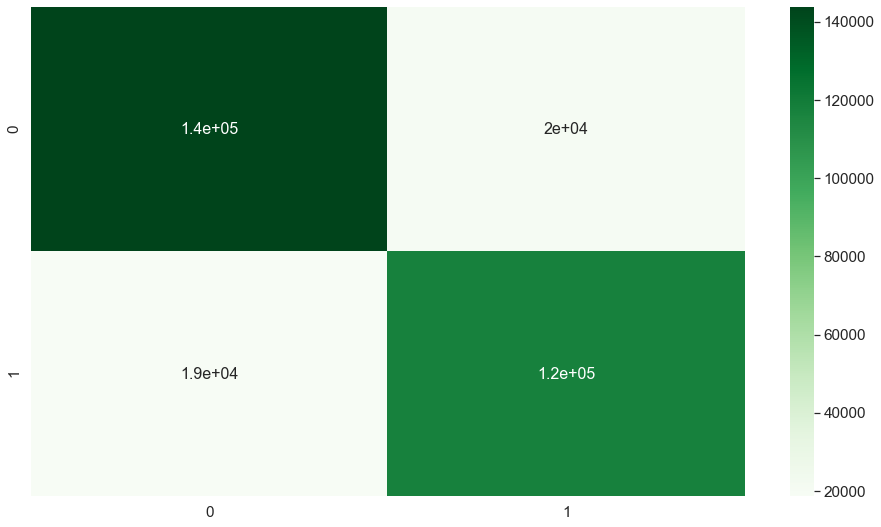

In [27]:
top_500_single_words = get_top_words(master_data_preprocessed, 0, 500)
for each_word in top_500_single_words.keys():
    master_data_preprocessed["Unigram: " + each_word] = master_data_preprocessed.content.str.count(" " + each_word + " ")
    print(each_word, "occurence", master_data_preprocessed["Unigram: " + each_word].sum(), "\n")
RF_cos_we_can_500 = predict_using_RandomForest(master_data_preprocessed)
show_scores_and_plot_matrices(RF_cos_we_can_500)
# 我是分隔線~~~

#### Approach 5: Region / Langauge features

In [24]:
master_data[["region", "language"]]

,region,language
0,Unknown,English
1,Unknown,English
2,Unknown,English
3,Unknown,English
4,Unknown,English
...,...,...
1201325,United States,English
1201326,United States,English
1201327,United States,English
1201328,United States,English


In [26]:
with_cultural_features = master_data_preprocessed.join(master_data[["region", "language"]])
with_cultural_features
# NB_cultural_features = predict_using_MultinomialNB(with_cultural_features)
# show_scores_and_plot_matrices(NB_cultural_features)

,content,account_category,troll,Unigram: Ð,Unigram: Ñ,Unigram: t,Unigram: co,Unigram: https,Unigram: ÐµÐ,Unigram: to,...,Unigram: ÑÐ,Unigram: ï,Unigram: you,Unigram: Trump,Unigram: Ñ,Unigram: ÑÑ,Unigram: with,Unigram: it,region,language
0,We have a sitting Democrat US Senator on tria...,RightTroll,1,0,0,1,1,1,0,0,...,0,0,1,0,0,0,0,0,Unknown,English
1,Marshawn Lynch arrives to game in anti Trump s...,RightTroll,1,0,0,1,1,1,0,1,...,0,0,0,1,0,0,0,0,Unknown,English
2,Daughter of fallen Navy Sailor delivers powerf...,RightTroll,1,0,0,1,1,1,0,0,...,0,0,0,0,0,0,0,0,Unknown,English
3,JUST IN President Trump dedicates Presidents ...,RightTroll,1,0,0,1,1,1,0,1,...,0,0,0,1,0,0,0,0,Unknown,English
4,19 000 RESPECTING our National Anthem StandF...,RightTroll,1,0,0,1,1,1,0,0,...,0,0,0,0,0,0,0,0,Unknown,English
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1201325,Thank you so much and I hope you have a great ...,RightTroll,1,0,0,1,1,1,0,0,...,0,0,2,0,0,0,0,0,United States,English
1201326,OutnumberedFNC ericmtyson I d start watchi...,RightTroll,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,United States,English
1201327,7 Ways to Discover Alien Planets https t c...,RightTroll,1,0,0,2,2,2,0,1,...,0,0,0,0,0,0,0,0,United States,English
1201328,Video shows woman shooting at burglars during ...,RightTroll,1,0,0,1,1,1,0,0,...,0,0,0,0,0,0,0,0,United States,English


#### Approach 6: TF-IDF / Bag of Words
References:
- https://stackabuse.com/text-classification-with-python-and-scikit-learn/

In [66]:
master_data_preprocessed_2 = master_data_preprocessed[["content", "account_category", "troll"]]
master_data_preprocessed_2.head(7)

,content,account_category,troll
0,We have a sitting Democrat US Senator on tria...,RightTroll,1
1,Marshawn Lynch arrives to game in anti Trump s...,RightTroll,1
2,Daughter of fallen Navy Sailor delivers powerf...,RightTroll,1
3,JUST IN President Trump dedicates Presidents ...,RightTroll,1
4,19 000 RESPECTING our National Anthem StandF...,RightTroll,1
5,Dan Bongino Nobody trolls liberals better th...,RightTroll,1
6,ð ð ð https t co MorL3AQW0z,RightTroll,1


In [67]:
documents = []
X = master_data_preprocessed_2["content"]
stemmer = WordNetLemmatizer()

for sen in range(0, len(X)):
    # Remove all the special characters
    document = re.sub(r'\W', ' ', str(X[sen]))
    
    # remove all single characters
    document = re.sub(r'\s+[a-zA-Z]\s+', ' ', document)
    
    # Remove single characters from the start
    document = re.sub(r'\^[a-zA-Z]\s+', ' ', document) 
    
    # Substituting multiple spaces with single space
    document = re.sub(r'\s+', ' ', document, flags=re.I)
    
    # Removing prefixed 'b'
    document = re.sub(r'^b\s+', '', document)
    
    # Converting to Lowercase
    document = document.lower()
    
    # Lemmatization
    document = document.split()

    document = [stemmer.lemmatize(word) for word in document]
    document = ' '.join(document)
    
    documents.append(document)
documents

['we have sitting democrat u senator on trial for corruption and you ve barely heard peep from the mainstream medium nedryun http co gh6g0d1oic',
 'marshawn lynch arrives to game in anti trump shirt judging by his sagging pant the shirt should say lynch v belt http co mlh1i30lzz',
 'daughter of fallen navy sailor delivers powerful monologue on anthem protest burn her nfl packer gear boycottnfl http co qdlfbgmeag',
 'just in president trump dedicates president cup golf tournament trophy to the people of florida texas and puerto rico http co z9wva4djae',
 '19 000 respecting our national anthem standforouranthemð ºð http co czutygamqv',
 'dan bongino nobody troll liberal better than donald trump exactly http co aigv93ac8j',
 'ð ð ð http co morl3aqw0z',
 'senatormenendez carmenyulincruz doesn matter that cnn doesn report on your crime this won change the fact that you re going down',
 'a much a hate promoting cnn article here they are admitting everything trump said about pr relief two day

In [69]:
# vectorizer = CountVectorizer(max_features=1500, min_df=5, max_df=0.7, stop_words=stopwords.words('english'))
# X = vectorizer.fit_transform(documents).toarray()

# Term frequency = (Number of Occurrences of a word)/(Total words in the document)
# IDF(word) = Log((Total number of documents)/(Number of documents containing the word))
tfidfconverter = TfidfVectorizer(max_features=1500, min_df=5, max_df=0.7, stop_words=stopwords.words('english'))
X = tfidfconverter.fit_transform(documents).toarray()

In [76]:
master_data_preprocessed_2

,content,account_category,troll
0,We have a sitting Democrat US Senator on tria...,RightTroll,1
1,Marshawn Lynch arrives to game in anti Trump s...,RightTroll,1
2,Daughter of fallen Navy Sailor delivers powerf...,RightTroll,1
3,JUST IN President Trump dedicates Presidents ...,RightTroll,1
4,19 000 RESPECTING our National Anthem StandF...,RightTroll,1
...,...,...,...
1201325,Thank you so much and I hope you have a great ...,RightTroll,1
1201326,OutnumberedFNC ericmtyson I d start watchi...,RightTroll,1
1201327,7 Ways to Discover Alien Planets https t c...,RightTroll,1
1201328,Video shows woman shooting at burglars during ...,RightTroll,1


In [75]:
X_frame = pd.DataFrame(X)
X_frame

,0,1,2,3,4,5,6,7,8,9,...,1490,1491,1492,1493,1494,1495,1496,1497,1498,1499
0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.418411,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1201325,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1201326,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1201327,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1201328,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [77]:
master_data_preprocessed_2_TFIDF = master_data_preprocessed_2.join(X_frame)
master_data_preprocessed_2_TFIDF

predict_using_MultinomialNB(master_data_preprocessed_2_TFIDF)

MemoryError: Unable to allocate 91.7 MiB for an array with shape (10, 1201330) and data type float64

MemoryError: Unable to allocate 64.2 MiB for an array with shape (7, 1201330) and data type float64

### Some other ideas:
    - (1) Region
        - A boolean column --> "is_English_speaking_country": [True, False]
    - (2) Language

In [ ]:
# Exploring country-specific or language specific models/visualizations 

master_data[["content", "region", "language", "account_category"]]

In [ ]:
master_data["region"].unique()

# "Region_int" : [0, 1, 2, 3, 4, 5] may not be good (too much info)

# "English_speaking_country": [True, False]

In [ ]:
master_data["language"].unique()